In [1]:
import os
import copy
import time
import cv2 
import numpy as np 
import random

from copy import deepcopy 
from collections import deque, defaultdict
from typing import Any, Dict, List, Optional, Set, Tuple, Union
from numpy.typing import ArrayLike, NDArray
from pydantic import dataclasses, validator

import dm_control
from dm_control import mujoco as dm_mujoco
from dm_control.utils.transformations import mat_to_quat, quat_to_euler
import mujoco
from rocobench.envs import SortOneBlockTask, CabinetTask, MoveRopeTask, SweepTask, MakeSandwichTask, PackGroceryTask, MujocoSimEnv, SimRobot, visualize_voxel_scene

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(np.array([-0.207, 2.256, 1.027])-np.array([-0.2, 1.05, 0.1])) # panda cam
print(np.array([0.223, -1.064, 0.758]) - np.array([-0.2, -0.07, 0.15])) # other cam

[-0.007  1.206  0.927]
[ 0.423 -0.994  0.608]


In [3]:
import numpy as np
positions = [
    (-0.05, 0.5, 0.15),
    (-0.25, 0.5, 0.15),
    (-0.5, 0.5, 0.15),
    (-0.75, 0.5, 0.15),
]
cameras = []
object_cams = []

def cross(a, b):
    return np.cross(a, b)

target = np.array([0, 0, 0])
positions = [np.array([0.5, 0, 1])]
for position in positions:
    vector = target - position
    cross_product = cross(vector, np.array([0, 0, 1]))
    # Calculate the unit vectors x and y
    x = cross_product / np.linalg.norm(cross_product)
    x = x/np.linalg.norm(x)
    y = np.cross(vector, x)
    y = y/np.linalg.norm(y)
    cpstring = " ".join([f"{i:.3f}" for i in position])
    xystring = " ".join([f"{i:.3f}" for i in y]) + " " + " ".join([f"{i:.3f}" for i in x])
    print(f"""<camera mode="trackcom" name='object_ pchdr' pos="{cpstring}" xyaxes="{xystring}"/>""")

<camera mode="trackcom" name='object_ pchdr' pos="0.500 0.000 1.000" xyaxes="0.894 -0.000 -0.447 0.000 1.000 -0.000"/>


In [2]:
tracked = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda']
env = PackGroceryTask(
    render_freq=2000,
    image_hw=(400,400), # Potentially important for getting RGBD images later on
    sim_forward_steps=300, # number of time steps forward that mujoco simulates before deciding that the llms need to pick an easier to optimize plan
    error_freq=30,
    error_threshold=1e-5,
    randomize_init=True,
    render_point_cloud=0, # Potentially useful for speeding up point fusion
    render_cameras=["face_panda","face_ur5e","teaser",],
    point_feature_cameras=tracked,
    one_obj_each=True, # TODO: Understand this
)

In [3]:
pointcloud = env.get_point_cloud()

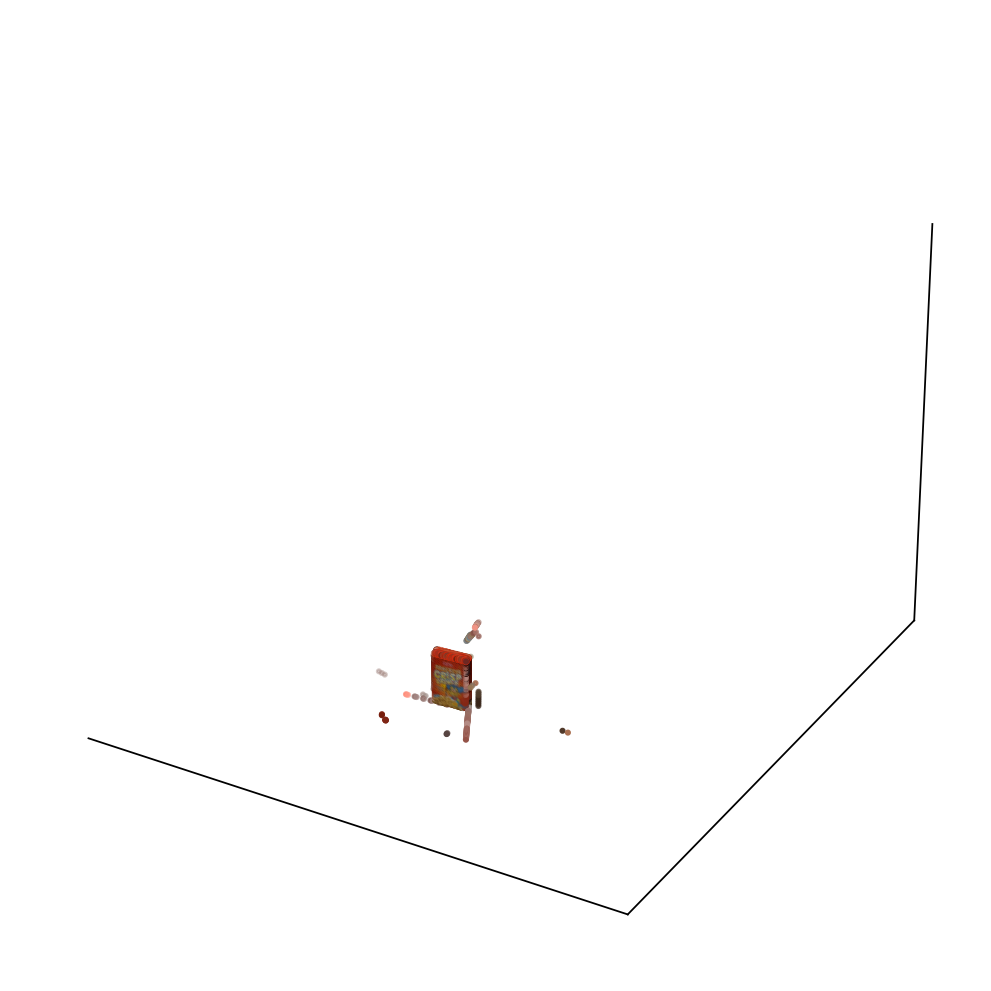

In [11]:
pointcloud['cereal'].show()

In [ ]:
import cv2
img = cv2.imread("rgb_image_sceneshot.png")
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
h, w = img.shape[:2]

focal_length = w / (2 * np.tan(45 * np.pi / 180))
K = np.array([[focal_length, 0, w / 2],
                  [0, focal_length, h / 2],
                  [0, 0, 1]])
dist_coeffs = np.zeros(4)
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (w, h), 1, (w, h))
undistorted_img = cv2.undistort(img, K, dist_coeffs, None, new_camera_matrix)
x, y, w, h = roi
undistorted_img = undistorted_img[y:y+h, x:x+w]
cv2.imwrite("undistorted_sceneshot.png", undistorted_img)

True

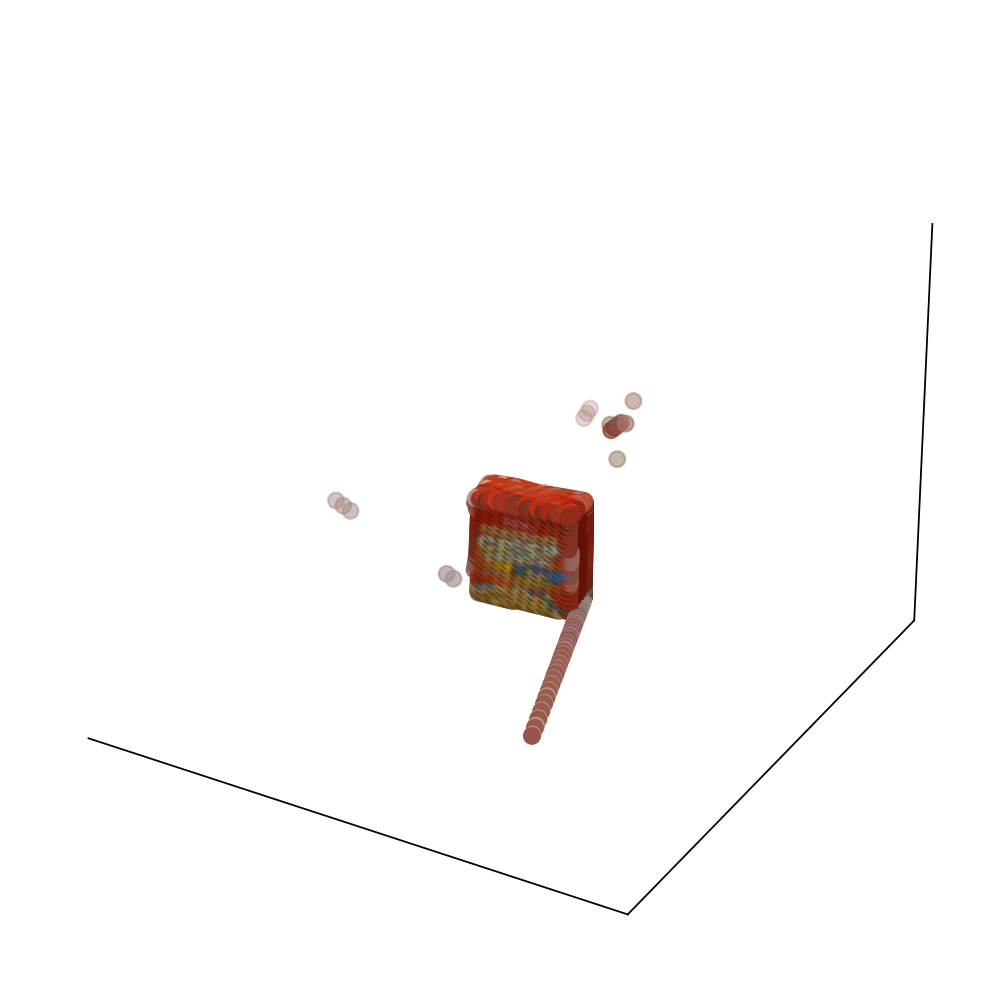

In [ ]:
obj = "cereal"
minx = min(pointcloud[obj].xyz_pts[:,0])
maxx = max(pointcloud[obj].xyz_pts[:,0])
miny = min(pointcloud[obj].xyz_pts[:,1])
maxy = max(pointcloud[obj].xyz_pts[:,1])
minz = min(pointcloud[obj].xyz_pts[:,2])
maxz = max(pointcloud[obj].xyz_pts[:,2])
width = maxx - minx
height = maxy - miny
depth = maxz - minz

# Find the maximum dimension
max_dim = max(width, height, depth)

# Calculate the center of the bounding box
center_x = (minx + maxx) / 2
center_y = (miny + maxy) / 2
center_z = (minz + maxz) / 2

# Calculate the minimum and maximum coordinates of the bounding box
bbox_min = (center_x - max_dim/2, center_y - max_dim/2, center_z - max_dim/2)
bbox_max = (center_x + max_dim/2, center_y + max_dim/2, center_z + max_dim/2)
bounds = (bbox_min, bbox_max)
pointcloud[obj].show(pts_size=50, bounds=bounds)

In [ ]:
print(f"|{env.model.id2name(48, 'body')}|")
print(env.model.geom(171))
print(f"|{env.model.name2id('apple_visual', 'geom')}|")